In [1]:
import atmospy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# disable warnings for demo purposes
warnings.filterwarnings("ignore")

atmospy.set_theme()

# this tutorial was completed using version:
atmospy.__version__

'0.1.2'

In [2]:
# Initialize an empty DataFrame
df_lcs = pd.DataFrame()

# Define the start and end months and years
start_month = 12
start_year = 2023
end_month = 1
end_year = 2024

# Function to generate month-year strings
def generate_month_year_strings(start_month, start_year, end_month, end_year):
    month_year_list = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        month_year_list.append(f"{year}_{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return month_year_list

# Generate the list of month-year strings
month_year_strings = generate_month_year_strings(start_month, start_year, end_month, end_year)

# Loop through each month-year string and load the CSV files
for month_year_string in month_year_strings:
    year, month = month_year_string.split('_')
    filename_tail = f"@devnode_{year}-{month}.csv"
    
    df_co = pd.read_csv(f"{month_year_string}/raw_CO-B4{filename_tail}", sep=',')
    # df_nh3 = pd.read_csv(f"{month_year_string}/raw_NH3-B1{filename_tail}", sep=',')
    # df_no2 = pd.read_csv(f"{month_year_string}/raw_NO2-B43F{filename_tail}", sep=',')
    # df_ox = pd.read_csv(f"{month_year_string}/raw_OX-B431{filename_tail}", sep=',')
    df_pm_opcn3 = pd.read_csv(f"{month_year_string}/raw_PM-OPCN3{filename_tail}", sep=',')
    df_pm_sps30 = pd.read_csv(f"{month_year_string}/raw_PM-SPS30{filename_tail}", sep=',')
    df_trh = pd.read_csv(f"{month_year_string}/raw_T_RH_P_BME280{filename_tail}", sep=',')
    
    # Combining all datasets using the "Čas" column
    df_temp = pd.merge(df_co, df_trh, on="Čas")
    # df_temp = pd.merge(df_temp, df_no2, on="Čas")
    # df_temp = pd.merge(df_temp, df_ox, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_sps30, on="Čas")
    
    # Calculating actual values for the WE (working electrode) and AE (auxiliary electrode) values
    df_temp["CO"] = df_temp["WE_CO"] - df_temp["AE_CO"]
    # df_temp["NH3"] = df_temp["WE_NH3"] - df_temp["AE_NH3"]
    # df_temp["NO2"] = df_temp["WE_NO2"] - df_temp["AE_NO2"]
    # df_temp["O3"] = df_temp["WE_O3"] - df_temp["AE_O3"]
      
    # Dropping the extra columns (including the pressure - that makes a negligible difference)
    df_temp = df_temp.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)
    
    # Renaming the "Čas" column
    df_temp = df_temp.rename(columns={'Čas': 'Time'})
    
    # Converting the time to a datetime
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    
    # 1h shift of the CSV data (CSV seems to be UTC+1, reference data UTC)
    df_temp['Time'] += pd.Timedelta(hours=1)
    
    # Set 'Time' column as the DataFrame index
    df_temp.set_index('Time', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean for each group
    df_temp_1h = df_temp.resample('1h').mean()
    
    # Assign the calculated hourly means back to the original DataFrame
    df_temp = df_temp_1h.reset_index()
    
    # Append the data to the main DataFrame
    df_lcs = pd.concat([df_lcs, df_temp], ignore_index=True)

# Renaming the "Time" column to "GMT"
df_lcs = df_lcs.rename(columns={'Time': 'GMT'})

# Set 'GMT' column as the DataFrame index
df_lcs.set_index('GMT', inplace=True)

# Print the data types of the final DataFrame
print(df_lcs.dtypes)

T          float64
RH         float64
p          float64
PM_1_x     float64
PM_2.5     float64
PM_10_x    float64
PM_1_y     float64
PM_2       float64
PM_10_y    float64
CO         float64
dtype: object


In [3]:
# The edited dataset has the "Celkem" values at the end of the data removed
#df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")
df_ref = pd.DataFrame()

df_ref = pd.read_csv('gmt_data/Nov-Feb_GMT_MarHory.csv', sep=';')
#df_ref = pd.read_csv('gmt_data/Mar-Jul_GMT_MarHory.csv', sep=';')

#df_ref = df_ref.rename(columns={
#        'Unnamed: 0': 'Time',
#        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
#        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
#        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
#        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
#        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
#        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
#        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
#        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
#        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
#})

#Apply the function to the entire column
df_ref['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_ref['GMT'] = df_ref['GMT'].dt.tz_localize('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_ref = df_ref.drop(["TIME"], axis=1)

# Pokud potřebujete změnit pouze určité sloupce, můžete specifikovat sloupce takto:

df_ref[['WDIR [deg]', 
        'HUMI [%]', 
        'PRES [hPa]', 
        'TEMP [°C]', 
        'PM10 [ug/m3]', 
        'PM25 [ug/m3]', 
        'PM01 [ug/m3]', 
        'O3 [ug/m3]', 
        'SO2 [ug/m3]', 
        'NO [ug/m3]', 
        'NO2 [ug/m3]', 
        'CO [ug/m3]']] = df_ref[['WDIR [deg]', 
                                 'HUMI [%]', 
                                 'PRES [hPa]', 
                                 'TEMP [°C]', 
                                 'PM10 [ug/m3]', 
                                 'PM25 [ug/m3]', 
                                 'PM01 [ug/m3]', 
                                 'O3 [ug/m3]', 
                                 'SO2 [ug/m3]', 
                                 'NO [ug/m3]', 
                                 'NO2 [ug/m3]', 
                                 'CO [ug/m3]']].astype('float64')

#df_ref.head()
#print(df_ref.describe())
print(df_ref.dtypes)

GMT             datetime64[ns, UTC]
WSPE [m/s]                  float64
WDIR [deg]                  float64
HUMI [%]                    float64
PRES [hPa]                  float64
TEMP [°C]                   float64
PM10 [ug/m3]                float64
PM25 [ug/m3]                float64
PM01 [ug/m3]                float64
O3 [ug/m3]                  float64
SO2 [ug/m3]                 float64
NO [ug/m3]                  float64
NO2 [ug/m3]                 float64
CO [ug/m3]                  float64
dtype: object


In [4]:
# Merge the two DataFrames on the 'Time' column
df = pd.merge(df_lcs, df_ref, on='GMT')
# Sorting the values by the "Time" attribute
df.sort_values(by="GMT")
# Check the correlation between 'CO' and 'CO [µg/m3]'
#correlation = df_merged['CO'].diff().corr(df_merged['CO [ug/m3]'].diff())
#print(f'Correlation between CO and CO [µg/m3]: {correlation}')

,GMT,T,RH,p,PM_1_x,PM_2.5,PM_10_x,PM_1_y,PM_2,PM_10_y,...,PRES [hPa],TEMP [°C],PM10 [ug/m3],PM25 [ug/m3],PM01 [ug/m3],O3 [ug/m3],SO2 [ug/m3],NO [ug/m3],NO2 [ug/m3],CO [ug/m3]
0,2023-12-01 01:00:00+00:00,-0.557333,85.205433,975.990000,13.114200,16.275167,20.386500,69.352000,75.364966,77.891067,...,1002.0,-1.0,34.0,NaN,NaN,5.0,12.7,12.9,55.8,660.7
1,2023-12-01 02:00:00+00:00,-0.484306,84.285889,976.000000,19.642194,25.440194,31.381194,69.984972,76.075278,78.651583,...,1002.0,-1.1,34.0,NaN,NaN,5.0,5.5,7.1,47.7,665.4
2,2023-12-01 03:00:00+00:00,-0.313639,83.112028,976.000000,16.668833,20.970278,25.540083,68.707556,74.642528,77.116889,...,1002.0,-1.0,32.0,NaN,NaN,5.0,5.5,7.7,49.9,659.3
3,2023-12-01 04:00:00+00:00,-0.342694,83.850833,976.000000,14.223778,17.920639,22.766444,71.632722,78.006611,80.819750,...,1002.0,-1.0,36.0,NaN,NaN,5.0,5.5,11.3,47.9,650.6
4,2023-12-01 05:00:00+00:00,-0.310722,83.884722,976.000000,16.265083,21.743806,27.976778,75.717639,82.767833,86.130972,...,1002.0,-1.1,36.0,NaN,NaN,5.0,5.5,13.0,45.7,654.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,2024-01-31 19:00:00+00:00,1.297056,83.746000,1003.916667,10.493250,13.133306,15.826833,66.159278,71.680556,73.822555,...,1033.0,1.9,32.0,NaN,NaN,35.6,5.5,2.5,19.5,285.1
1484,2024-01-31 20:00:00+00:00,1.461389,83.998389,1003.016667,10.438139,13.214000,15.967722,64.434389,69.774944,71.815194,...,1032.0,2.1,30.0,NaN,NaN,34.4,5.5,2.5,20.2,276.1
1485,2024-01-31 21:00:00+00:00,1.361750,84.647778,1002.250000,11.494944,14.510889,17.163861,70.583667,76.515861,78.853528,...,1031.0,1.9,35.0,NaN,NaN,28.3,5.5,2.5,24.1,315.9
1486,2024-01-31 22:00:00+00:00,1.161306,85.039028,1001.319444,11.845889,14.879778,17.638556,71.157333,77.173361,79.574389,...,1030.0,1.8,35.0,NaN,NaN,29.0,5.5,2.5,23.0,308.2


In [5]:
start_date = '2024-01-07'
end_date = '2024-01-12'

# Filter the DataFrame
sel_df = df[df['GMT'] >= start_date]
sel_df = sel_df[sel_df['GMT'] <= end_date]

# Sorting the values by the "GMT" attribute
df = sel_df.sort_values(by="GMT")

#df.head()
print(df[['TEMP [°C]','HUMI [%]','PRES [hPa]']].describe())

        TEMP [°C]    HUMI [%]   PRES [hPa]
count  121.000000  121.000000   121.000000
mean    -8.856198   91.528926  1026.933884
std      4.690449    8.420287     7.950614
min    -18.300000   66.000000  1010.000000
25%    -12.100000   89.000000  1022.000000
50%     -8.800000   94.000000  1028.000000
75%     -4.700000   99.000000  1034.000000
max     -0.700000   99.000000  1036.000000


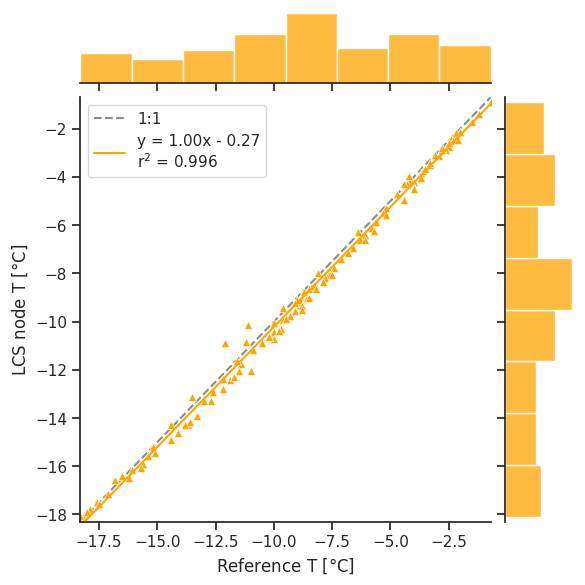

In [6]:
t = atmospy.regplot(
    data=df,
    x="TEMP [°C]", 
    y="T",
    color="orange",
    marker='^',
#    fit_reg=False
)
t.set_axis_labels(xlabel="Reference $T$ [$°C$]", ylabel="LCS node $T$ [$°C$]")

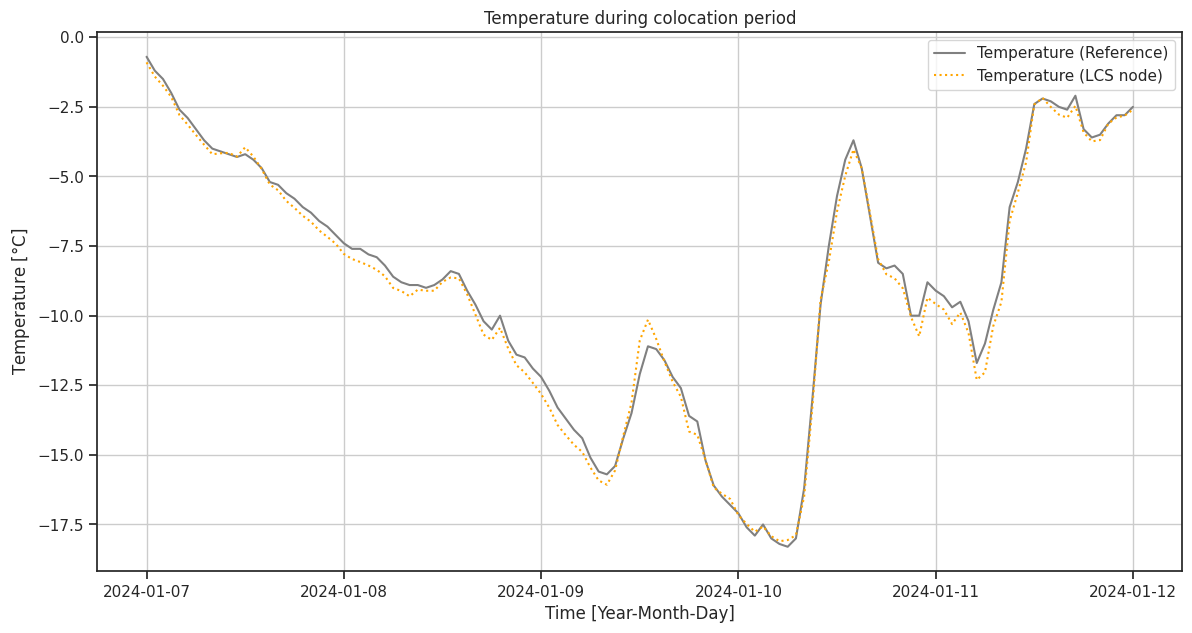

In [7]:
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['TEMP [°C]'],  color="grey",label='Temperature (Reference)')
plt.plot(df['GMT'], df['T'], color="orange", linestyle=":", label='Temperature (LCS node)')

plt.title('Temperature during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('Temperature [$°C$]')
plt.legend()
plt.grid(True)
plt.show()

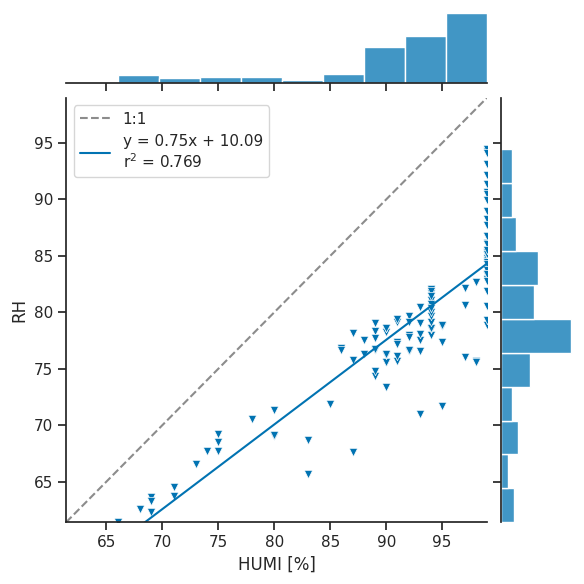

In [8]:
rh = atmospy.regplot(
    data=df,
    x="HUMI [%]", 
    y="RH",
    color="b",
    marker='v',
#    fit_reg=False
)
t.set_axis_labels(xlabel="Reference $RH$ [$\%$]", ylabel="LCS node $RH$ [$\%$]")

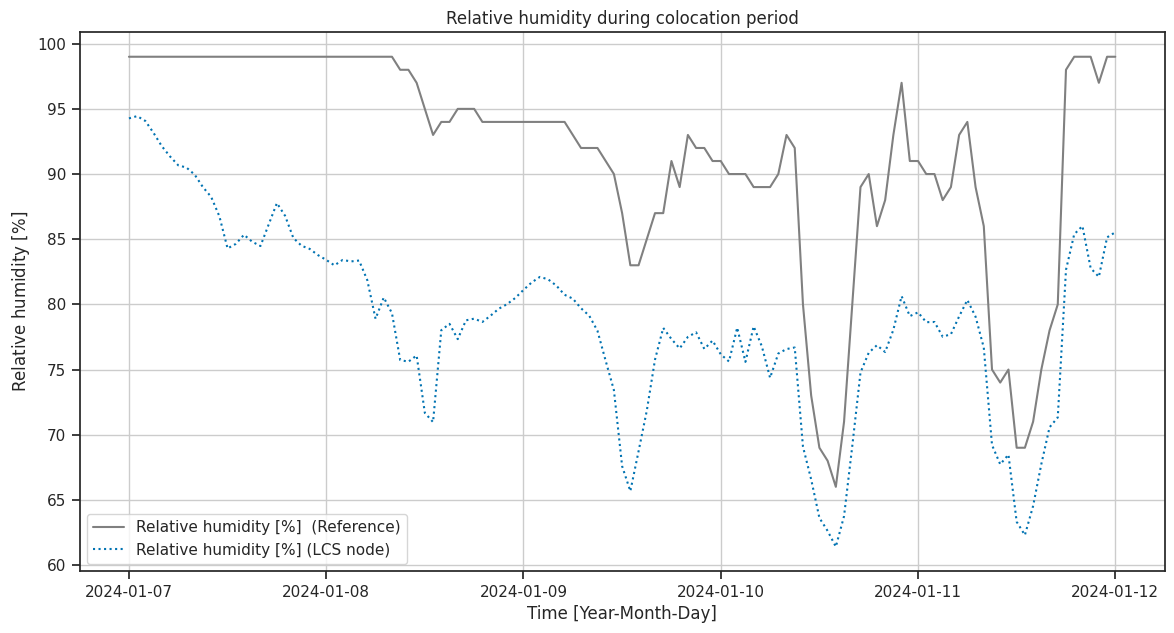

In [9]:
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['HUMI [%]'],  color="grey",label='Relative humidity [%]  (Reference)')
plt.plot(df['GMT'], df['RH'], color="b", linestyle=":", label='Relative humidity [%] (LCS node)')

plt.title('Relative humidity during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('Relative humidity [$\%$]')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
df["T"] = pd.to_numeric(df["T"], errors='coerce') + 273.15
df["CO"] = pd.to_numeric(df["CO"], errors='coerce') * 4394 + (-0.693)* pd.to_numeric(df["T"], errors='coerce')
df["CO [ug/m3]"] = pd.to_numeric(df["CO [ug/m3]"], errors='coerce')

#df_filter = df[df["CO [ug/m3]"] > 200]
#df_subfilter = df_filter[df_filter["CO [ug/m3]"] < 400]

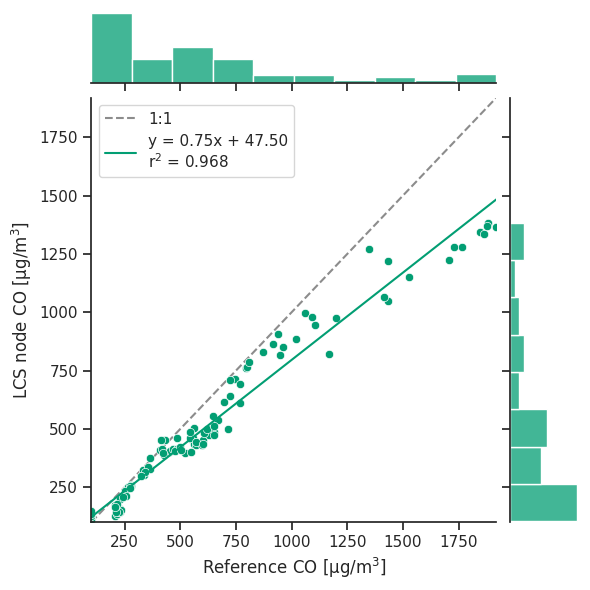

In [11]:
co = atmospy.regplot(
    data=df,
#    data=df_filter,
#    data=df_subfilter,
    x="CO [ug/m3]", 
    y="CO",
    color="g",
    marker='o',
#    fit_reg=False
)
co.set_axis_labels(xlabel="Reference $CO$ [$µg/m^{3}$]", ylabel="LCS node $CO$ [$µg/m^{3}$]")

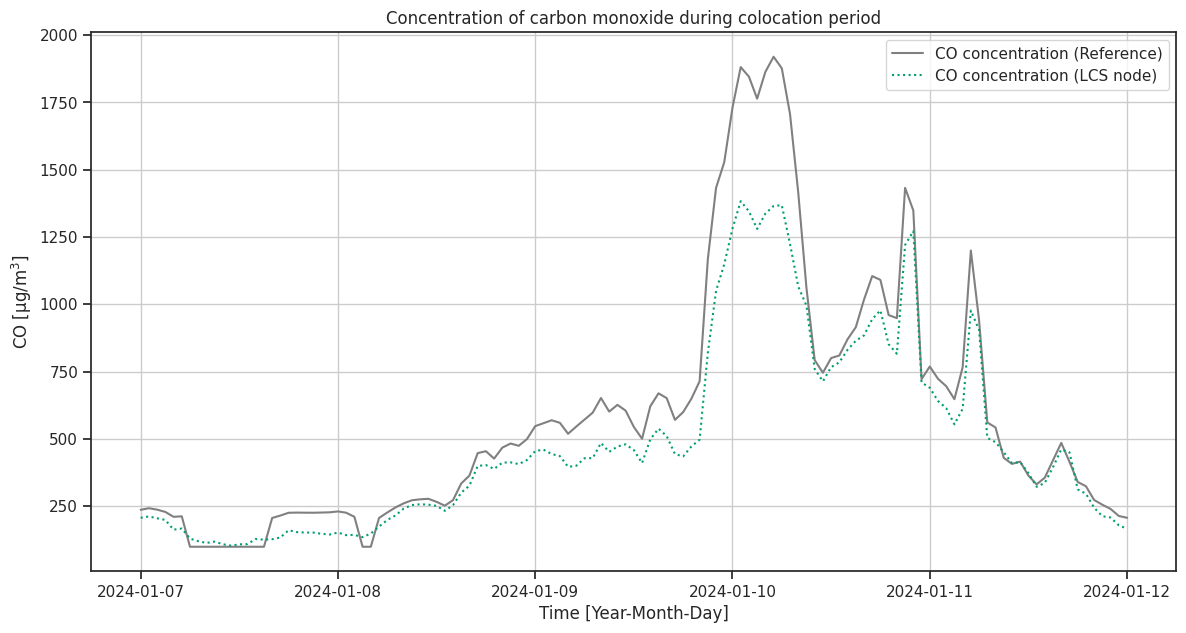

In [12]:
# Plotting
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['CO [ug/m3]'],  color="grey",label='CO concentration (Reference)')
plt.plot(df['GMT'], df['CO'], color="g", linestyle=":", label='CO concentration (LCS node)')

plt.title('Concentration of carbon monoxide during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('CO [$µg/m^3$]')
plt.legend()
plt.grid(True)
plt.show()

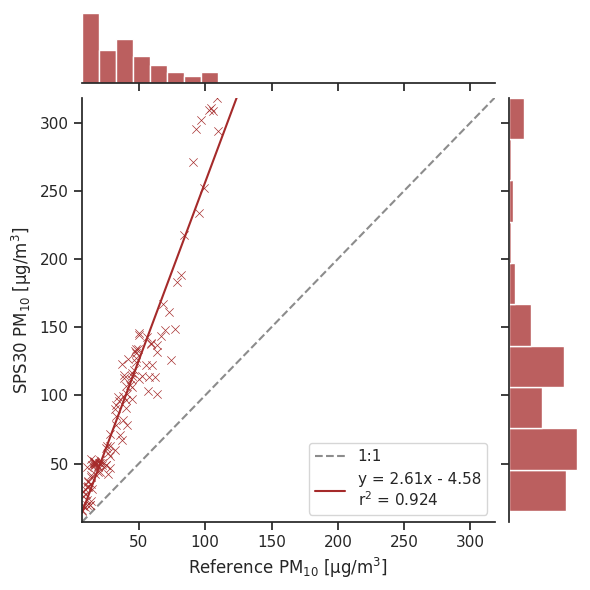

In [13]:
df["PM_10_y"] = pd.to_numeric(df["PM_10_y"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM10 [ug/m3]", 
    y="PM_10_y",   
    color="brown",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{10}$ [$µg/m^{3}$]", ylabel="SPS30 $PM_{10}$ [$µg/m^{3}$]")

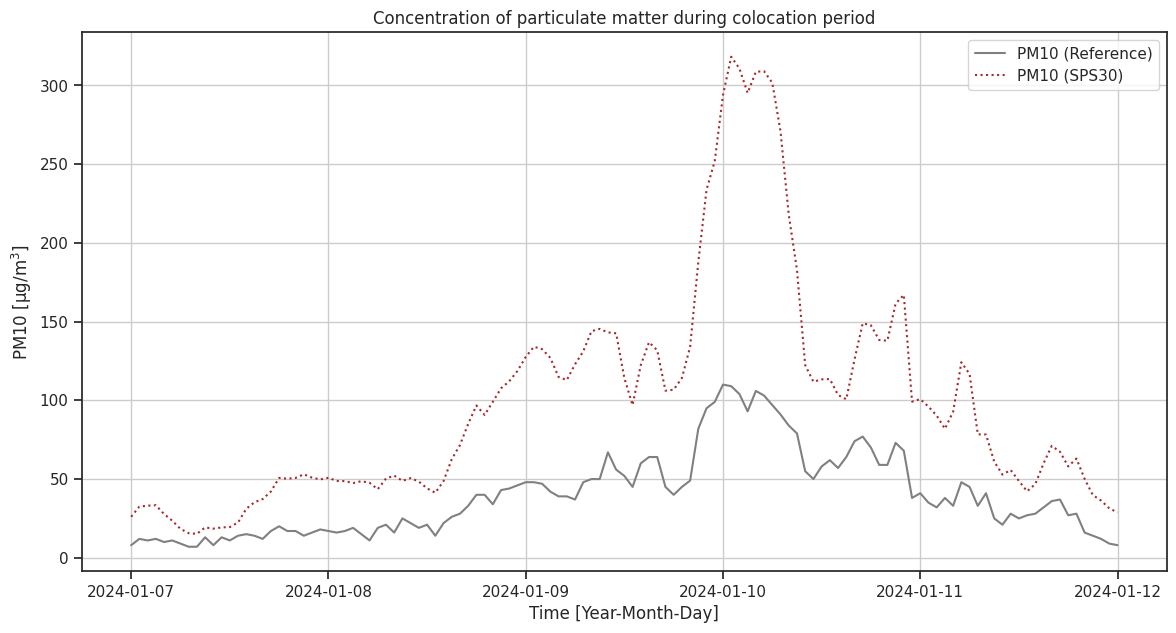

In [14]:
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['PM10 [ug/m3]'],  color="grey",label='PM10 (Reference)')
plt.plot(df['GMT'], df['PM_10_y'], color="brown", linestyle=":", label='PM10 (SPS30)')

plt.title('Concentration of particulate matter during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('PM10 [$µg/m^3$]')
plt.legend()
plt.grid(True)
plt.show()

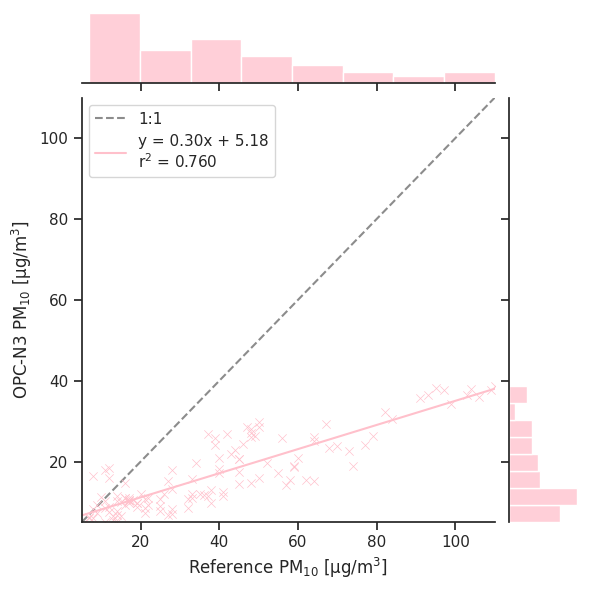

In [15]:
df["PM_10_x"] = pd.to_numeric(df["PM_10_x"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM10 [ug/m3]", 
    y="PM_10_x",   
    color="pink",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{10}$ [$µg/m^{3}$]", ylabel="OPC-N3 $PM_{10}$ [$µg/m^{3}$]")

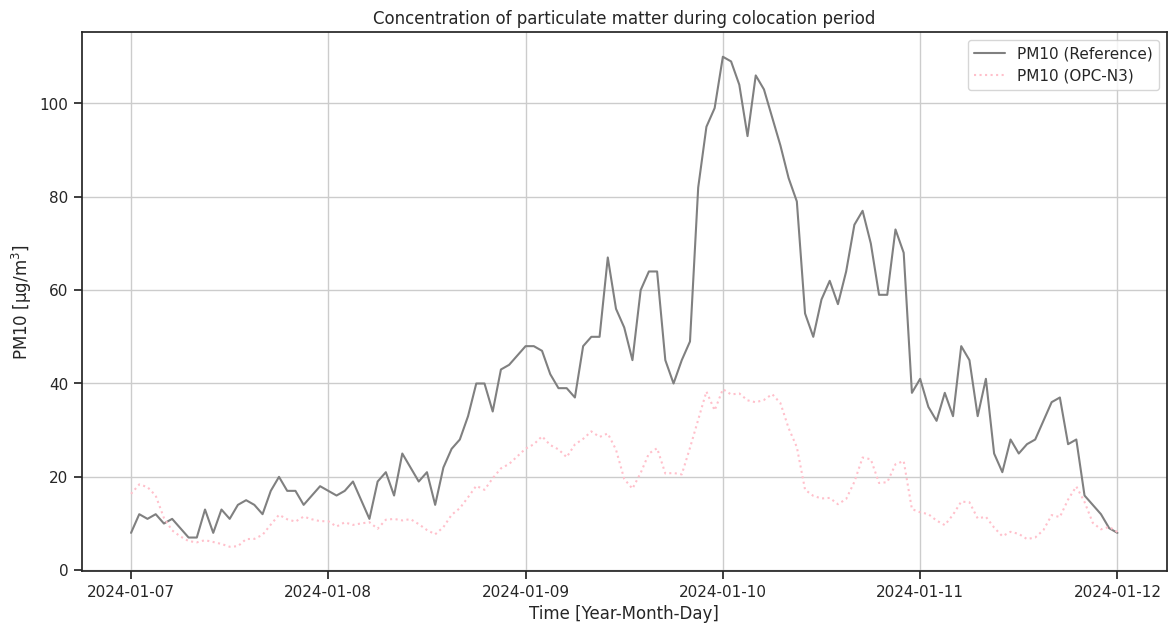

In [16]:
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['PM10 [ug/m3]'],  color="grey",label='PM10 (Reference)')
plt.plot(df['GMT'], df['PM_10_x'], color="pink", linestyle=":", label='PM10 (OPC-N3)')

plt.title('Concentration of particulate matter during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('PM10 [$µg/m^3$]')
plt.legend()
plt.grid(True)
plt.show()